In [1]:
from pathlib import Path
import lenet_model
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

In [2]:
# MODEL_NAME = "quantized_lenet5_mnist_2144.pth"
MODEL_NAME = "quantized_lenet5_mnist_20250703_1003.pth"
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

### LOAD WEIGHTS

In [3]:
weights = torch.load(MODEL_SAVE_PATH)
# print(weights.keys())  # Print the keys of the weights dictionary
# print(weights['c1.weight'])  # Print the first element of the first channel
# print(weights['c1.weight'][0, 0, 0, 0])  # Print the first element of the first channel
# print(weights['c1.weight'].int_repr()[0, 0, 0, 0])  # Print the first element of the first channel
# print(weights['c1.scale'])
# print(weights['c1.zero_point'])
# print(weights['c2.weight'])
# print(weights['c2.scale'])
# print(weights['c2.zero_point'])

c:\Users\gunaw\anaconda3\envs\ml\lib\site-packages\torch\_utils.py:425: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [4]:
# odict_keys(['c1.weight', 'c1.bias', 'c2.weight', 'c2.bias', 'c3.weight', 'c3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
# odict_keys(['quant.scale', 'quant.zero_point', 'c1.weight', 'c1.bias', 'c1.scale', 'c1.zero_point', 'c2.weight', 'c2.bias', 'c2.scale', 'c2.zero_point', 'c3.weight', 'c3.bias', 'c3.scale', 'c3.zero_point', 'fc1.scale', 'fc1.zero_point', 'fc1._packed_params.dtype', 'fc1._packed_params._packed_params', 'fc2.scale', 'fc2.zero_point', 'fc2._packed_params.dtype', 'fc2._packed_params._packed_params'])
# print(weights.keys())
# print(weights['quant.scale'])
# print(weights['quant.zero_point'])
c1_weight = weights['c1.weight']
c1_weight.cpu()
c1_bias = weights['c1.bias']
c1_weight.cpu()
print(type(c1_weight),c1_bias)
# weights has been quantized, we dont need to quantize it again
# print(type(weights['c1.scale'].item()))
print(weights['c1.zero_point'].item())

<class 'torch.Tensor'> Parameter containing:
tensor([-0.1901, -0.1153,  0.0569, -0.3014, -0.3366, -0.0769],
       requires_grad=True)
68


tensor([[[[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
           17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
          [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 

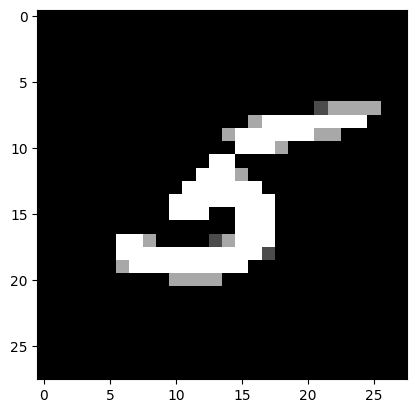

In [5]:
from matplotlib import pyplot as plt
# load image
IMAGE_NAME = "img_01.png"
IMAGE_PATH = Path(Path.cwd() / "results" / "images" / IMAGE_NAME)

dataset_mean = 0.132515
dataset_std = 0.310480
quant_scale = weights['quant.scale'].item()
quant_zero_point = weights['quant.zero_point'].item()

img = Image.open(IMAGE_PATH).convert('L')  # 'L' for grayscale

pix = np.array(img.getdata()).reshape(img.size[1], img.size[0]).astype(np.uint8)  # shape: [28, 28]
plt.imshow(img, cmap='gray')
# PyTorch pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # [H, W] → [1, H, W], uint8 → float32 in [0,1]
    # transforms.Normalize(mean=[dataset_mean], std=[dataset_std])
])
img_tensor = transform(img)  # shape: [1, 28, 28], float32
# print(img_tensor.dtype)
img_quantized = torch.quantize_per_tensor(img_tensor, scale=quant_scale, zero_point=quant_zero_point, dtype=torch.quint8).unsqueeze(0)  # shape: [1, 1, 28, 28]
print(img_quantized.int_repr())  # Print the quantized integer representation
# load the image as numpy array (manual code)
img_manual_array = np.array(img).astype(np.uint8)  # shape: [28, 28]
# normalize the image manually
scale = 1 / (255* dataset_std)
offset = -dataset_mean / dataset_std
# quantize manually
img_int8_norm = img_manual_array.astype(np.float32) * scale + offset
# int8_tensor = torch.round(img_tensor / quant_scale + quant_zero_point).clamp(-128, 127).to(torch.int8)
img_int8_quantized = np.round(img_int8_norm / quant_scale + quant_zero_point)
img_int8_quantized = np.clip(img_int8_quantized, -128, 127).astype(np.int8)
# img_int8_quantized = np.clip(img_int8_quantized, 0, 255).astype(np.uint8)


In [228]:
# import torch.nn as nn
# import pandas as pd
# # set backend to quantized
# torch.backends.quantized.engine = 'fbgemm'
# # Create a quantized conv2d layer (same shape as c1)
# conv_q = nn.quantized.Conv2d(
#     in_channels=1,
#     out_channels=6,
#     kernel_size=5,
#     stride=1,
#     padding=2,
#     dtype=torch.quint8
# )
# conv_q_non_quantized = nn.Conv2d(
#     in_channels=1,
#     out_channels=6,
#     kernel_size=5,
#     stride=1,
#     padding=2,
# )
# # apply weight and bias to conv_q
# conv_q.set_weight_bias(weights['c1.weight'], weights['c1.bias'])
# # apply weights to conv_q_non_quantized
# conv_q_non_quantized.weight = nn.Parameter(c1_weight.int_repr().to(torch.float32))  # convert to float32
# conv_q_non_quantized.bias = nn.Parameter(c1_bias)

# # print('conv_q_weight', conv_q.weight().int_repr())
# # print('conv_q_non_quantized weight', conv_q_non_quantized.weight)
# # print('weight difference when loading to layer', torch.sum(torch.abs(conv_q.weight().int_repr() - c1_weight.int_repr())))

# img_int8_quantized_tensor = torch.tensor(img_int8_quantized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(torch.float32)  # shape: [1, 1, 28, 28]
# img_quantized = torch.quantize_per_tensor(img_tensor, scale=weights['quant.scale'], zero_point=weights['quant.zero_point'], dtype=torch.quint8).unsqueeze(0)  # shape: [1, 1, 28, 28]

# # print(img_quantized.dtype)  
# # print(img_int8_quantized_tensor.dtype)
# # print(img_quantized.shape)  
# # print(img_int8_quantized_tensor.shape)  
# # print(img_quantized.int_repr()) 
# print('diff on input image', torch.sum(img_quantized.int_repr() - img_int8_quantized_tensor))  

# with torch.no_grad():
#     conv_output = conv_q(img_quantized)  # conv_q is nn.quantized.Conv2d
#     conv_output_manual_img = conv_q_non_quantized(img_int8_quantized_tensor)  # conv_q is nn.quantized.Conv2d
# torch.set_printoptions(profile="full")
# print(conv_output[0,0,:,:])
# print(conv_output_manual_img[0,0,:,:].to(torch.int8))
# # # Optional: flatten if needed
# # y_flat = y_int8.flatten()
# # # Save as binary or C array
# # np.savetxt("conv_output.txt", y_flat, fmt='%d', delimiter=',')


#### RUN CONV2D.PREPACK

In [229]:
# --- 1) Prepare your data and params ---
img_quantized = torch.quantize_per_tensor(img_tensor, scale=weights['quant.scale'], zero_point=weights['quant.zero_point'], dtype=torch.quint8).unsqueeze(0)  # shape: [1, 1, 28, 28]
# torch.save(img_quantized, 'img_01.png_quantized_manual.pt')
# Quantized input (QUInt8)
# x_fp32: float32 tensor [1,1,H,W]
x_fp32 = img_tensor
x_q = img_quantized
# Quantized weight (QInt8) and float bias
w_q = weights['c1.weight']         # torch.qint8
b_fp32 = weights['c1.bias']        # torch.float32
# b_fp32 = torch.tensor([0,0,0,0,0,0], dtype=torch.float32)  # Use zero bias for simplicity

# Stride/pad/dilation/groups
stride = (1, 1)
padding = (2, 2)
dilation = (1, 1)
groups = 1

# The output quant params (from your model)
y_scale = weights['c1.scale']  
y_zp    = weights['c1.zero_point']
# --- 2) Pack the weights & bias once --- 
packed_w = torch.ops.quantized.conv2d_prepack(
    w_q, b_fp32,
    stride, padding, dilation, groups
)

# --- 3) Do the quantized conv2d --- 
y_q = torch.ops.quantized.conv2d(
    x_q,                # QUInt8 input
    packed_w,           # packed QInt8 weight + bias
    y_scale, y_zp       # output scale & zero_point
)

# y_q is a torch.quint8 tensor: it’s the exact same as conv_q(x_q)
# print(y_q.shape, y_q.dtype, y_q.q_scale(), y_q.q_zero_point())
# print(y_q[0,0,0,:])
print(y_q.int_repr()[0,0,0,:])  # raw uint8 values

tensor([67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
        67, 67, 67, 67, 67, 67, 67, 67, 67, 67], dtype=torch.uint8)


In [230]:
# Step 1: Re-create model and set QAT config
model_fp32 = lenet_model.LeNet5()
model_fp32.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_fp32 , inplace=True)
print(model_fp32)

LeNet5(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (dequant): DeQuantStub()
  (c1): Conv2d(
    1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
     

### TRY TO CREATE MANUAL FIXEDPOINT CONV BASED OFF FBGEMM HERE

In [28]:

import torch.nn.functional as F
import numpy as np

def requantize_fixed_point(src: np.ndarray, multiplier: int, right_shift: int, zero_point: int) -> np.ndarray:
    """
    src: int32 numpy array (accumulator values)
    multiplier: fixed-point multiplier (int)
    right_shift: number of bits to right-shift
    zero_point: output zero point (usually uint8)
    """
    src = src.astype(np.int64)  # promote to avoid overflow in multiplication
    ab_64 = src * multiplier

    # Add rounding offset (nudge)
    nudge = 1 << max(0, right_shift - 1)
    ab_64_rounded = ab_64 + nudge

    # Perform requantization (right shift + zero point offset)
    quantized_down = zero_point + (ab_64_rounded >> right_shift)
    # Clip to uint8 range
    
    quantized_clipped = torch.clip(torch.tensor(quantized_down), 0, 255)

    return quantized_clipped.to(torch.uint8)


def int8_conv2d_integer_only(
    x_q,                # torch.quint8 input  [B, C_in, H, W]
    w_q,                # torch.qint8 weights [C_out, C_in, kH, kW]
    b_int32,            # torch.int32 bias   [C_out]
    x_zp, w_zp, z_y,    # zero points (ints)
    M, R,               # per‐channel multiplier (int32) & shift (int)
    stride=1,           # int or (stride_h, stride_w)
    padding=0           # int or (pad_h, pad_w)
):
    # --- unpack stride & padding ---
    if isinstance(stride, int):
        stride_h = stride_w = stride
    else:
        stride_h, stride_w = stride
    if isinstance(padding, int):
        pad_h = pad_w = padding
    else:
        pad_h, pad_w = padding

    B, C_in, H, W = x_q.shape
    C_out, _, kH, kW = w_q.shape

    # --- dequantized ints ---
    # x_int: int32, shape [B, C_in, H, W]
    x_int = x_q.int().to(torch.int32) - x_zp
    # print(x_int)
    # pad on H and W dims: (left, right, top, bottom)
    x_int = F.pad(x_int, (pad_w, pad_w, pad_h, pad_h))

    # prepare weights once
    # w_int: int32, shape [C_out, C_in, kH, kW]
    w_int = w_q.int_repr().to(torch.int32) - w_zp
    # print(w_int)
    # compute output spatial dims
    H_p, W_p = H + 2*pad_h, W + 2*pad_w
    H_out = (H_p - kH) // stride_h + 1
    W_out = (W_p - kW) // stride_w + 1

    # allocate output (int32 accumulator)
    y_int32 = torch.zeros((B, C_out, H_out, W_out), dtype=torch.int32)

    for b in range(B):
        for oc in range(C_out):
            m = M[oc].item()
            params = {
                'multiplier': m,        # example Q31 multiplier
                'right_shift': R,              # shift to get back to int8 range
                'zero_point': z_y               # typical for quantized uint8
            }
            for i in range(H_out):
                for j in range(W_out):
                    acc = np.int32(0)
                    start_i = i * stride_h
                    start_j = j * stride_w
                    for ic in range(C_in):
                        # vectorized inner loop if you like
                        for ki in range(kH):
                            for kj in range(kW):
                                xv = x_int[b, ic, start_i+ki, start_j+kj].item()
                                wv = w_int[oc, ic, ki, kj].item()
                                acc += xv * wv
                    acc += b_int32[oc].item()

                    y_int32[b,oc,i,j] = requantize_fixed_point(acc, **params)
                # print('\n')
    # clamp to [0,255] and cast to uint8
    y_uint8 = y_int32.clamp(0, 255).to(torch.uint8)
    return y_uint8


In [ ]:
import math
img_int8_quantized_tensor = torch.tensor(img_int8_quantized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(torch.float32)  # shape: [1, 1, 28, 28]

bias_int32 = weights['c1.bias'] / (weights['quant.scale'].item()  * weights['c1.weight'].q_scale()) # convert bias to int32
bias_int32 = torch.round(bias_int32).to(torch.int32)
# bias_int32 = torch.tensor([0,0,0,0,0,0], dtype=torch.int32)  # Use zero bias for simplicity
# print(bias_int32)
scale_weight = torch.tensor(weights['c1.weight'].q_scale())
scale_x = weights['quant.scale'].item()  # scale of input
scale_y = weights['c1.scale'].item()  # scale of output
# --- 2) Compute the “real” per-channel multiplier m_o ------------
#   m_o = (s_x * s_w[o]) / s_y
multipler = scale_weight.mul_(scale_x / scale_y)   # in-place to save memory, shape [C_out]
print('multiplier', multipler)

# --- 3) Choose R so that max(|M[o]|) <= 2^31 - 1 ------------------
# We need M[o] = round(m[o] * 2^R) to fit in int32.
# So R <= floor( log2((2^31 - 1) / max(|m[o]|)) )
max_m = multipler.abs().max().item()
print('max_m', multipler.abs().max().item())
INT32_MAX = 2**31 - 1
print('INT32_MAX', INT32_MAX)
R_max = math.floor(math.log2(INT32_MAX / max_m))
print('R_max', R_max)
# clamp R to [0, 31] if you like
R = min(31, max(0, R_max))
# --- 4) Compute the integer multipliers M[o] ----------------------
#   M[o] = round(m[o] * 2^R)
M = torch.round(multipler * (2**R)).to(torch.int32)  # Tensor[C_out]
print(f"Using R = {R}")
print("First few fixed-point multipliers:", M)
M_vec = M.repeat(c1_weight.shape[0])        
conv2d_result_manual = int8_conv2d_integer_only(
    img_quantized.int_repr(),
    # img_int8_quantized_tensor,
    c1_weight,
    bias_int32, 
    weights['quant.zero_point'].item(), weights['c1.weight'].q_zero_point(), weights['c1.zero_point'],
    M=M_vec, R=R,
    stride=1,padding=2)
print(conv2d_result_manual.shape)

multiplier tensor(0.0008)
max_m 0.0007882966310717165
INT32_MAX 2147483647
R_max 41
Using R = 31
First few fixed-point multipliers: tensor(1692854, dtype=torch.int32)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_15932\3416531865.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantized_clipped = torch.clip(torch.tensor(quantized_down), 0, 255)


torch.Size([1, 6, 28, 28])


In [61]:
print(weights['c1.zero_point'])
conv2d_result_manual[0,5,:,:]


tensor(68)


tensor([[67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 68, 68, 69, 70, 70, 69, 68, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 69, 70, 71,
         71, 71, 71, 71, 73, 73, 72, 70, 68, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 69, 71, 72, 73, 75,
  

In [169]:
import pandas as pd
print(conv2d_result_manual.shape)
print(weights['quant.zero_point'])
channel_0 = torch.tensor(pd.read_csv('c1_result_0_c.csv', header=None).values)[:,:28]
print('channel 0' ,torch.sum(channel_0.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,0,:,:]))
# channel_1 = torch.tensor(pd.read_csv('c1_result_1_c.csv', header=None).values)
# print(channel_1.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,1,:,:])
# channel_2 = torch.tensor(pd.read_csv('c1_result_2_c.csv', header=None).values)
# print(torch.sum(channel_2.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,2,:,:]))
channel_3 = torch.tensor(pd.read_csv('c1_result_3_c.csv', header=None).values)[:,:28]
print('channel 3' ,torch.sum(channel_3.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,3,:,:]))
channel_5 = torch.tensor(pd.read_csv('c1_result_5_c.csv', header=None).values)[:,:28]
print('channel 5' , torch.sum(channel_5.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,5,:,:]))
# channel_5_no_zp = torch.tensor(pd.read_csv('c1_result_5_c_no_zp.csv', header=None).values)
# print(channel_5_no_zp+weights['c1.zero_point']- channel_5)
# print(torch.sum(channel_5_no_zp.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,5,:,:]))


torch.Size([1, 6, 28, 28])
tensor([17])
channel 0 tensor(0., dtype=torch.float64)
channel 3 tensor(0., dtype=torch.float64)
channel 5 tensor(0., dtype=torch.float64)


In [ ]:
# multiplier 1692854
# acc 38890
# prod 1410582620
# nudge 32768
# rounded 1410615388
# requant 1004632

In [262]:
arr = bias_int32.numpy().astype(np.int32)
c_array = ', '.join(str(x) for x in arr)
print(f"int32_t bias_int32[{arr.size}] = {{{c_array}}};")

int32_t bias_int32[6] = {-1842, -1117, 551, -2920, -3261, -745};


In [ ]:
print(conv2d_result_manual.shape)
print(conv2d_result_manual[0,0,0:10,0:10])

print(y_q.int_repr()[0,0,0:10,0:10])
print(torch.sum(y_q.int_repr() - conv2d_result_manual))



torch.Size([1, 6, 28, 28])
tensor([[67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 65],
        [67, 67, 67, 67, 64, 65, 68, 66, 64, 65],
        [67, 67, 67, 64, 64, 67, 68, 68, 70, 73],
        [67, 67, 65, 65, 69, 73, 70, 73, 77, 75]], dtype=torch.uint8)
tensor([[67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67],
        [67, 67, 67, 67, 67, 67, 67, 67, 67, 65],
        [67, 67, 67, 67, 64, 65, 68, 66, 64, 65],
        [67, 67, 67, 64, 64, 67, 68, 68, 70, 73],
   

In [234]:
# torch.save(conv2d_result_manual, f'{IMAGE_NAME}_c1.pt')
print(f'{IMAGE_NAME}_c1.pt')


img_05.png_c1.pt


### create manual maxpool2d function

In [174]:
def maxpool2d(input_array, kernel_size=2, stride=2):
    """
    Performs 2D max pooling on a 4D input tensor.

    Parameters:
        input_array: np.ndarray with shape (N, C, H, W)
        kernel_size: int or tuple of (kh, kw)
        stride: int or tuple of (sh, sw)

    Returns:
        output_array: np.ndarray with shape (N, C, H_out, W_out)
    """
    if isinstance(kernel_size, int):
        kh, kw = kernel_size, kernel_size
    else:
        kh, kw = kernel_size

    if isinstance(stride, int):
        sh, sw = stride, stride
    else:
        sh, sw = stride

    N, C, H, W = input_array.shape
    H_out = (H - kh) // sh + 1
    W_out = (W - kw) // sw + 1

    output = np.zeros((N, C, H_out, W_out), dtype=input_array.dtype)

    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * sh
                    h_end = h_start + kh
                    w_start = j * sw
                    w_end = w_start + kw
                    window = input_array[n, c, h_start:h_end, w_start:w_end]
                    output[n, c, i, j] = np.max(window)
    return output

In [175]:
c1_maxpool = maxpool2d(conv2d_result_manual.numpy(), kernel_size=2, stride=2)
c1_maxpool_pytorch = F.max_pool2d(
    conv2d_result_manual, kernel_size=2, stride=2)
print('compare maxpool results', np.sum(c1_maxpool - c1_maxpool_pytorch.numpy()))
# print(c1_maxpool)
# torch.save(torch.tensor(c1_maxpool), f'{IMAGE_NAME}_pool_c1.pt')

compare maxpool results 0


In [182]:
c1mp_channel_0 = torch.tensor(pd.read_csv('c1_maxpool_0_c.csv', header=None).values)[:,:14]
print(torch.sum(c1mp_channel_0.unsqueeze(0) - c1_maxpool_pytorch[0,0,:,:]))
c1mp_channel_4 = torch.tensor(pd.read_csv('c1_maxpool_4_c.csv', header=None).values)[:,:14]
print(torch.sum(c1mp_channel_4.unsqueeze(0) - c1_maxpool_pytorch[0,4,:,:]))
# print('channel 0' ,torch.sum(channel_0.unsqueeze(0).unsqueeze(0) - conv2d_result_manual[0,0,:,:]))


tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [237]:
# (torch.tensor(c1_maxpool), f'{IMAGE_NAME}_pool_c1.pt')

### RELU FROM MAX(0,X) MAX(ZERO_POINT,X)

In [238]:
c1_relu = torch.clamp(torch.tensor(c1_maxpool), min=weights['c1.zero_point'])

print(c1_relu)

tensor([[[[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 72, 72, 72, 72, 71, 68, 68, 68, 68],
          [68, 68, 73, 73, 77, 77, 74, 68, 68, 68, 68, 68, 68, 68],
          [68, 71, 73, 72, 68, 68, 69, 69, 69, 70, 68, 68, 68, 68],
          [68, 68, 68, 68, 70, 71, 70, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 71, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 68, 69, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 69, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 68, 69, 68, 68, 68, 68, 68, 68],
          [68, 68, 68, 68, 68, 68, 69, 68, 68, 68, 68, 68, 68, 68]],

         [[68, 68, 68, 68, 68, 68, 68, 68, 68,

In [239]:
# torch.save(c1_relu, f'{IMAGE_NAME}_relu_c1.pt')

### PREP C2 CONV FUNCTION ON PYTORCH


In [240]:
# Quantized weight (QInt8) and float bias
c2_w_q = weights['c2.weight']         # torch.qint8
c2_b_fp32 = weights['c2.bias']        # torch.float32
# Stride/pad/dilation/groups
c2_stride = (1, 1)
c2_padding = (0, 0)
c2_dilation = (1, 1)
c2_groups = 1

# The output quant params (from your model)
c2_y_scale = weights['c2.scale']  
c2_y_zp    = weights['c2.zero_point']
# --- 2) Pack the weights & bias once --- 
c2_packed_w = torch.ops.quantized.conv2d_prepack(
    c2_w_q, c2_b_fp32,
    c2_stride, c2_padding, c2_dilation, c2_groups
)
# Assuming you have quantized uint8 data already (no float conversion) 
c1_maxpool_quint8_wrapped = torch._empty_affine_quantized(c1_maxpool.shape, scale=1, zero_point=0, dtype=torch.quint8)
c1_maxpool_quint8_wrapped.copy_(torch.from_numpy(np.float32(c1_maxpool)))
# torch.quantize_per_tensor(img_tensor, scale=weights['c1.scale'], zero_point=weights['c1.zero_point'], dtype=torch.quint8).unsqueeze(0)
# --- 3) Do the quantized conv2d --- 
print(c1_maxpool_quint8_wrapped)
c2_q_pytorch = torch.ops.quantized.conv2d(
    c1_maxpool_quint8_wrapped,                # QUInt8 input
    c2_packed_w,           # packed QInt8 weight + bias
    c2_y_scale, c2_y_zp       # output scale & zero_point
)

tensor([[[[67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67.],
          [67., 67., 67., 68., 67., 72., 72., 72., 72., 71., 67., 67., 67., 67.],
          [67., 67., 73., 73., 77., 77., 74., 67., 67., 67., 67., 67., 67., 67.],
          [67., 71., 73., 72., 62., 66., 69., 69., 69., 70., 67., 67., 67., 67.],
          [67., 67., 62., 68., 70., 71., 70., 67., 67., 68., 66., 67., 67., 67.],
          [67., 67., 68., 71., 68., 67., 67., 67., 68., 66., 66., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 67., 66., 65., 67., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 66., 68., 66., 68., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 68., 69., 65., 67., 67., 67., 67.],
          [67., 67., 67., 67., 67., 67., 67., 69., 67., 67., 68., 67., 67., 67.],
          [67., 

# Print weights and size of the model after quantization

In [241]:
c2_bias_int32 = torch.round(weights['c2.bias'] / (weights['c1.scale'].item()  * weights['c2.weight'].q_scale())).to(torch.int32) # convert bias to int32
c2_scale_weight = torch.tensor(weights['c2.weight'].q_scale())
c2_scale_x = weights['c1.scale'].item()  # scale of input
c2_scale_y = weights['c2.scale'].item()  # scale of output
c2_multipler = c2_scale_weight.mul_(c2_scale_x / c2_scale_y)   # in-place to save memory, shape [C_out]

c2_max_m = c2_multipler.abs().max().item()
INT32_MAX = 2**31 - 1
c2_R_max = math.floor(math.log2(INT32_MAX / c2_max_m))
# clamp R to [0, 31] if you like
c2_R = min(31, max(0, c2_R_max))
# --- 4) Compute the integer multipliers M[o] ----------------------
#   M[o] = round(m[o] * 2^R)
c2_M = torch.round(c2_multipler * (2**c2_R)).to(torch.int32)  # Tensor[C_out]
print(f"Using R = {c2_R}")
print("First few fixed-point multipliers:", c2_M)
c2_M_vec = c2_M.repeat(weights['c2.weight'].shape[0])
c1_maxpool_tensor = torch.tensor(c1_maxpool, dtype=torch.float32)
# C_out, _, kH, kW = w_q.shape
c2_conv2d_result_manual = int8_conv2d_integer_only(
    c1_relu,
    weights['c2.weight'],
    c2_bias_int32, 
    weights['c1.zero_point'].item(), weights['c2.weight'].q_zero_point(), weights['c2.zero_point'],
    M=c2_M_vec, R=c2_R,
    stride=1,padding=0)

Using R = 31
First few fixed-point multipliers: tensor(4544963, dtype=torch.int32)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\613243976.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantized_clipped = torch.clip(torch.tensor(quantized_down), 0, 255)


In [242]:
print(c2_conv2d_result_manual[0,0,:,:])
# torch.save(c2_conv2d_result_manual, f'{IMAGE_NAME}_c2.pt')

tensor([[83, 81, 79, 78, 79, 80, 80, 80, 81, 81],
        [79, 78, 78, 77, 75, 75, 79, 80, 80, 81],
        [81, 79, 78, 78, 77, 80, 86, 85, 81, 80],
        [82, 80, 81, 83, 82, 84, 87, 85, 79, 79],
        [81, 81, 81, 80, 78, 82, 85, 85, 78, 78],
        [79, 78, 79, 78, 76, 80, 85, 83, 77, 78],
        [78, 79, 80, 80, 79, 83, 86, 83, 77, 79],
        [82, 82, 82, 81, 81, 85, 86, 81, 75, 80],
        [83, 83, 83, 81, 82, 86, 85, 77, 75, 82],
        [83, 83, 82, 81, 83, 86, 83, 74, 77, 84]], dtype=torch.uint8)


In [243]:
c2_maxpool = maxpool2d(c2_conv2d_result_manual.numpy(), kernel_size=2, stride=2)
print(c2_maxpool.shape)
torch.save(torch.tensor(c2_maxpool), f'{IMAGE_NAME}_pool_c2.pt')

(1, 16, 5, 5)


In [244]:
c2_relu = torch.clamp(torch.tensor(c2_maxpool), min=weights['c2.zero_point'])
# torch.save(c2_relu, f'{IMAGE_NAME}_relu_c2.pt')

In [245]:
c3_bias_int32 = torch.round(weights['c3.bias'] / (weights['c2.scale'].item()  * weights['c3.weight'].q_scale())).to(torch.int32) # convert bias to int32
c3_scale_weight = torch.tensor(weights['c3.weight'].q_scale())
c3_scale_x = weights['c2.scale'].item()  # scale of input
c3_scale_y = weights['c3.scale'].item()  # scale of output
c3_multipler = c3_scale_weight.mul_(c3_scale_x / c3_scale_y)   # in-place to save memory, shape [C_out]

c3_max_m = c3_multipler.abs().max().item()
INT32_MAX = 2**31 - 1
c3_R_max = math.floor(math.log2(INT32_MAX / c3_max_m))
# clamp R to [0, 31] if you like
c3_R = min(31, max(0, c3_R_max))
# --- 4) Compute the integer multipliers M[o] ----------------------
#   M[o] = round(m[o] * 2^R)
c3_M = torch.round(c3_multipler * (2**c3_R)).to(torch.int32)  # Tensor[C_out]
print(f"Using R = {c3_R}")
print("First few fixed-point multipliers:", c3_M)
c3_M_vec = c3_M.repeat(weights['c3.weight'].shape[0])
c2_maxpool_tensor = torch.tensor(c2_relu, dtype=torch.float32)
# C_out, _, kH, kW = w_q.shape
c3_conv2d_result_manual = int8_conv2d_integer_only(
    c2_maxpool_tensor,
    weights['c3.weight'],
    c3_bias_int32, 
    weights['c2.zero_point'].item(), weights['c3.weight'].q_zero_point(), weights['c3.zero_point'],
    M=c3_M_vec, R=c3_R,
    stride=1,padding=0)

Using R = 31
First few fixed-point multipliers: tensor(8327137, dtype=torch.int32)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\2978365005.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c2_maxpool_tensor = torch.tensor(c2_relu, dtype=torch.float32)
C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\613243976.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantized_clipped = torch.clip(torch.tensor(quantized_down), 0, 255)


In [246]:
c3_conv2d_result_manual_flatten = torch.flatten(c3_conv2d_result_manual).unsqueeze(0)
c3_relu = torch.clamp(torch.tensor(c3_conv2d_result_manual_flatten), min=weights['c3.zero_point'])
# torch.save(c3_relu, f'{IMAGE_NAME}_relu_c3.pt')
print(c3_relu)

tensor([[74, 74, 74, 74, 78, 74, 74, 74, 74, 74, 74, 74, 74, 77, 74, 74, 74, 74,
         74, 74, 76, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 74, 83, 74, 74, 74,
         74, 74, 79, 74, 74, 74, 74, 74, 78, 74, 78, 74, 78, 74, 74, 74, 74, 74,
         74, 74, 74, 76, 74, 74, 74, 74, 74, 74, 74, 79, 74, 74, 74, 76, 74, 74,
         74, 74, 74, 74, 74, 77, 78, 74, 75, 74, 74, 76, 74, 74, 74, 74, 74, 75,
         74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 74, 74, 74, 74,
         74, 74, 74, 74, 79, 74, 74, 74, 76, 74, 74, 76]], dtype=torch.uint8)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\4183517818.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c3_relu = torch.clamp(torch.tensor(c3_conv2d_result_manual_flatten), min=weights['c3.zero_point'])


In [247]:
def requantize_fbgemm(acc: int, M: int, R: int, zp: int) -> int:
    prod = np.int64(acc) * np.int64(M)
    # saturating rounding doubling high mul
    nudge = np.int64(1) << 31
    hi31  = int((prod + nudge) >> 32)
    # now downshift by (31 - R)
    scaled = hi31 >> (31 - R)
    return max(0, min(255, scaled + zp))

def quantized_linear(
    x_q,                # torch.quint8 [N, in_features]
    w_q,                # torch.qint8  [out_features, in_features]
    bias_int32,         # torch.int32  [out_features]
    x_zp, w_zp, y_zp,   # ints
    M, R,                # Tensor[out_features], int shift
    input_scale=0, output_scale=0,
):
    N, in_f = x_q.shape
    out_f, _ = w_q.shape

    # 1) subtract zero-points
    x_int = x_q.int().to(torch.int32) - x_zp
    w_int = w_q.int_repr().to(torch.int32) - w_zp  # per-channel if needed
    w_scale = w_q.q_scale()
    # 2) int32 matmul + bias
    y_int32 = torch.zeros((N, out_f), dtype=torch.int32)
    for n in range(N):
        for o in range(out_f):
            acc = torch.dot(x_int[n], w_int[o])   # int32
            # print(acc.dtype)
            acc = acc + bias_int32[o]             # int32
            # 3) requantize
            # saturating rounding, high‐mul, then shift:
            prod = int(acc) * int(M.item())
            # add rounding nudge
            acc_q = (prod + (1 << (R - 1))) >> R
            # print(acc_q)
            # add output zero‐point and clamp
            acc_q = acc_q + y_zp
            y_int32[n, o] = max(0, min(255, acc_q))
            y_int32[n, o] = requantize_fbgemm(acc_q,M=M,R=R,zp=y_zp)
            # rounding to 8 bits
            z_out  = torch.round((acc)*((input_scale*w_scale)/output_scale))
            # z_out = saturate(z_out)
            y_int32[n, o] = z_out

    return y_int32.to(torch.uint8)

def quantize_multiplier(real_scale):
    if real_scale == 0:
        return 0, 0
    significand, exponent = np.frexp(real_scale)  # real_scale = s * 2^e, |s| in [0.5,1)
    M = int(torch.round(significand * (1 << 31)))      # Q31 fixed-point
    R = -exponent                                # right shift after the high-mul
    return M, R

# def requantize_fixed_point(src: np.ndarray, multiplier: int, right_shift: int, zero_point: int) -> np.ndarray:
#     """
#     src: int32 numpy array (accumulator values)
#     multiplier: fixed-point multiplier (int)
#     right_shift: number of bits to right-shift
#     zero_point: output zero point (usually uint8)
#     """
#     src = src.astype(np.int64)  # promote to avoid overflow in multiplication
#     ab_64 = src * multiplier

#     # Add rounding offset (nudge)
#     nudge = 1 << max(0, right_shift - 1)
#     ab_64_rounded = ab_64 + nudge

#     # Perform requantization (right shift + zero point offset)
#     quantized_down = zero_point + (ab_64_rounded >> right_shift)
#     # Clip to uint8 range
#     quantized_clipped = torch.clip(quantized_down, 0, 255)

#     return quantized_clipped.to(torch.uint8)

In [74]:
torch.set_printoptions(profile="full")
weights['fc1._packed_params._packed_params'][1]

Parameter containing:
tensor([-5.5541e-02, -1.1212e-01,  1.4950e-01, -2.1750e-02, -7.9550e-02,
        -2.6794e-02, -1.0098e-02, -3.7917e-02,  4.5647e-02,  1.2435e-01,
         1.4925e-02, -5.4840e-02,  4.2010e-02, -1.4417e-01, -8.1558e-02,
         2.1808e-01, -1.0489e-01,  5.7456e-02, -5.4745e-05, -1.3483e-02,
        -9.8336e-02,  1.2907e-01, -2.0111e-02, -4.8898e-02, -1.3850e-01,
         9.4622e-02,  2.5789e-01, -3.4394e-02,  7.4453e-02,  2.1444e-02,
         1.6184e-01,  5.2490e-02,  1.2724e-01,  3.5700e-02,  1.1433e-01,
        -8.9549e-03, -5.0973e-02, -2.3144e-02,  1.7422e-01, -7.0503e-02,
        -7.1462e-02, -1.0133e-01, -1.1298e-01, -7.0165e-02, -2.4324e-02,
         1.8525e-01, -1.2957e-01,  7.9836e-02,  1.8914e-01, -1.8761e-02,
         1.2058e-01,  1.4163e-01, -6.8169e-02,  5.9301e-02,  2.9853e-02,
         7.0051e-03, -8.2605e-02,  4.7995e-02, -1.1337e-01, -2.4698e-02,
        -1.0141e-01,  2.1510e-01,  3.1197e-01, -1.5831e-01, -8.5254e-02,
        -2.0909e-02,  4.8620e

In [249]:
import torch
import numpy as np

def quantized_linear_manual(x_q, w_q, b_fp32, s_x, s_w, s_y, x_zp, w_zp, z_y):
    """
    Simulates PyTorch quantized.Linear using int32 math + requantization

    x_q:  [N, in_features]  (torch.quint8)
    w_q:  [out_features, in_features]  (torch.qint8)
    b_fp32: [out_features]  (torch.float32)
    s_x, s_w, s_y: float scales
    x_zp, w_zp, z_y: int zero-points
    """
    x_int = x_q.int() - x_zp                 # [N, in_features], int32
    w_int = w_q.int_repr().int() - w_zp      # [out_features, in_features], int32

    # Step 1: int32 matmul
    acc = torch.matmul(x_int, w_int.T)       # [N, out_features], int32

    # Step 2: quantize bias (to match accumulator scale)
    bias_int32 = torch.round(b_fp32 / (s_x * s_w)).to(torch.int32)

    # Step 3: add bias
    acc += bias_int32

    # Step 4: requantization (fixed-point scale + shift)
    real_scale = (s_x * s_w) / s_y
    M, R = quantize_scale(real_scale)

    # Step 5: fixed-point multiply + shift + zp + clamp
    acc = requantize_fixed_point_tensor(acc, M, R, z_y)

    return acc.to(torch.uint8)

def quantize_scale(real_scale):
    """Convert real scale to fixed-point multiplier and shift"""
    significand, exponent = np.frexp(real_scale)
    M = int(torch.round(significand * (1 << 31)))   # Q31 multiplier
    R = -exponent
    return M, R

def requantize_fixed_point_tensor(acc, M, R, z_y):
    """
    Apply saturating rounding high-mul + shift and add output zp
    acc: int32 tensor
    M: int
    R: int
    z_y: output zp
    """
    acc = acc.to(torch.int64)
    prod = acc * M
    # Apply rounding
    prod += (1 << 30)
    prod = prod >> 31  # this is saturating rounding high mul
    # Apply right shift
    prod = prod >> (R - 1)
    # Add zp and clamp
    acc_q = prod + z_y
    acc_q = torch.clamp(acc_q, 0, 255)
    return acc_q.to(torch.uint8)


In [250]:
fc1_bias_fp32 = weights['fc1._packed_params._packed_params'][1]
fc1_scale_in = weights['c3.scale']
fc1_scale_weight = weights['fc1._packed_params._packed_params'][0].q_scale()
# Run manual quantized linear
y_manual = quantized_linear_manual(
    c3_relu, weights['fc1._packed_params._packed_params'][0], fc1_bias_fp32,
    s_x=fc1_scale_in, s_w=fc1_scale_weight, s_y=weights['fc1.scale'],
    x_zp=weights['c3.zero_point'].item(), w_zp=weights['fc1._packed_params._packed_params'][0].q_zero_point(), z_y=weights['fc1.zero_point'].item()
)

fc1_relu = torch.clamp(torch.tensor(y_manual), min=weights['fc1.zero_point'])
print(fc1_relu)


tensor([[67, 67, 67, 73, 70, 67, 72, 67, 70, 67, 67, 67, 67, 67, 67, 67, 67, 67,
         67, 68, 71, 73, 67, 79, 77, 67, 74, 67, 78, 75, 67, 83, 67, 67, 67, 67,
         67, 67, 67, 67, 75, 81, 67, 85, 67, 67, 67, 74, 81, 67, 67, 71, 67, 67,
         67, 69, 67, 77, 67, 67, 67, 67, 67, 67, 67, 70, 80, 68, 67, 67, 73, 67,
         67, 67, 67, 79, 67, 67, 67, 71, 67, 67, 67, 67]], dtype=torch.uint8)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\238433758.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  significand, exponent = np.frexp(real_scale)
C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\865937651.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fc1_relu = torch.clamp(torch.tensor(y_manual), min=weights['fc1.zero_point'])


In [251]:
# torch.save(fc1_relu, f'{IMAGE_NAME}_fc1_relu.pt')

In [253]:
fc2_bias_fp32 = weights['fc2._packed_params._packed_params'][1]
fc2_scale_in = weights['fc1.scale']
fc2_scale_weight = weights['fc2._packed_params._packed_params'][0].q_scale()
# Run manual quantized linear
fc2_manual = quantized_linear_manual(
    fc1_relu, weights['fc2._packed_params._packed_params'][0], fc2_bias_fp32,
    s_x=fc2_scale_in, s_w=fc2_scale_weight, s_y=weights['fc2.scale'],
    x_zp=weights['fc1.zero_point'].item(), w_zp=weights['fc2._packed_params._packed_params'][0].q_zero_point(), z_y=weights['fc2.zero_point'].item()
)
print(fc2_manual)


tensor([[ 57,  70,  69,  77,  68,  73,  43, 105,  64,  80]], dtype=torch.uint8)


C:\Users\gunaw\AppData\Local\Temp\ipykernel_16680\238433758.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  significand, exponent = np.frexp(real_scale)
